In [1]:
from transformers import Speech2TextFeatureExtractor, Speech2TextModel
import torch
import torchaudio
import numpy as np

from auditory_cortex.regression import transformer_regression
from auditory_cortex.dataset import Neural_Data
# from auditory_ctx.models.speech_recognition import SpeechRecognitionModel


dir = '/Users/akshita/Documents/Research/Makin/data'
subject = '200206'
neural_data = Neural_Data(dir, subject)


model = Speech2TextModel.from_pretrained("facebook/s2t-small-librispeech-asr")
feature_extractor = Speech2TextFeatureExtractor.from_pretrained("facebook/s2t-small-librispeech-asr")

dir = '/Users/akshita/Documents/Research/Makin/data'
subject = '200206'
neural_data = Neural_Data(dir, subject)
reg = transformer_regression(dir, subject)

for param in model.parameters():
    param.requires_grad = False

sig = torch.nn.Sigmoid()

Some weights of the model checkpoint at facebook/s2t-small-librispeech-asr were not used when initializing Speech2TextModel: ['lm_head.weight']
- This IS expected if you are initializing Speech2TextModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Speech2TextModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Speech2TextModel were not initialized from the model checkpoint at facebook/s2t-small-librispeech-asr and are newly initialized: ['model.encoder.embed_positions.weights', 'model.decoder.embed_positions.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[W NNPACK.cpp:79] Could not initialize NNPACK! Rea

In [2]:
model

Speech2TextModel(
  (encoder): Speech2TextEncoder(
    (conv): Conv1dSubsampler(
      (conv_layers): ModuleList(
        (0): Conv1d(80, 1024, kernel_size=(5,), stride=(2,), padding=(2,))
        (1): Conv1d(512, 512, kernel_size=(5,), stride=(2,), padding=(2,))
      )
    )
    (embed_positions): Speech2TextSinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): Speech2TextEncoderLayer(
        (self_attn): Speech2TextAttention(
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (activation_fn): ReLU()
        (fc1): Linear(in_features=256, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=256, bi

In [3]:
def get_beta_eta(sent=1, layer=0):
    # train_list = np.arange(1,451).tolist()
    z_vals_train, n_vals_train = reg.get_layer_values_and_spikes(layer=layer, win=80, sent_list=[sent])
    # print(z_vals_train.shape, n_vals_train.shape)
    
    beta = np.linalg.solve(z_vals_train.T.dot(z_vals_train), (z_vals_train.T).dot(n_vals_train))
    return beta, n_vals_train, z_vals_train
# beta.requires_grad = True

In [6]:
class Hook():
    def __init__(self, model, layer_name, backward=False):

        layer = dict([*model.named_modules()])[layer_name]
        layer.__name__ = layer_name
        # self.hook_inp = spect_inp.register_backward_hook()
        # if backward == False:

        self.hook_fwd = layer.register_forward_hook(self.hook_fn_f)
        self.hook_bwd = layer.register_backward_hook(self.hook_fn_b)
        # else:

    def hook_fn_f(self, layer, input, output):
        # print("i", input)
        # print("0", output)

        self.input_f = input
        self.output_f = output#.requires_grad_(True)

    def hook_fn_b(self, layer, input, output):
        # print("i", input)
        # print("0", output)

        self.input_b = input
        self.output_b = output
    
    
    def close(self):
        self.hook.remove()

def back_prop_step(net_in, net, layer):     
    # aud_processed = processor(net_in, padding=True, sampling_rate=16000, return_tensors="pt")['input_features']
    # print(aud_processed)
    net_in.requires_grad = True
    decoder_input_ids = torch.tensor([[1, 1]]) * net.config.decoder_start_token_id
    # op = torch.optim.SGD([aud_processed], lr=0.1, momentum=0.9)
    # net.zero_grad()
    optimizer.zero_grad()

    # print(net_in.requires_grad, decoder_input_ids.requires_grad)
    hook = Hook(net, layer, backward=True)
    # net.eval()

    net_out = net(net_in, decoder_input_ids=decoder_input_ids)
    # print(hook.output_f.shape)
    beta_z = sig(torch.matmul(beta.T, hook.output_f))
    # print(beta_z[0].shape)
    loss = (1 - beta_z[0]).mean()
    loss.backward()
    optimizer.step()

    # return net_in.grad.data

def get_opt_input(spect, net, layer, iterations, lr):

    for i in range(iterations):
        back_prop_step(spect, net, layer)
        # print(spect)
        # gradients = get_gradients(spect, net, layer)
        # print(torch.max(gradients))
        # spect.data = spect.data + lr * gradients.data
    
    # return spect


In [ ]:
sents = []
betas = []
for i in range(499):
    sents.append(neural_data.audio(i))
    beta, _, _ = get_beta_eta(i+1, 0)
    betas.append(beta)

betas = torch.tensor(np.array(betas), dtype=torch.float32)

In [ ]:

beta.shape

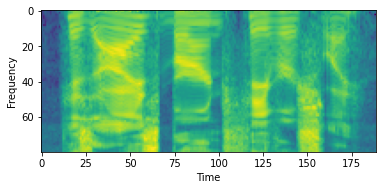

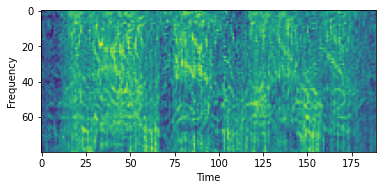

In [7]:
aud = neural_data.audio(0)
beta, eta_val, z_val = get_beta_eta(1, 1)
beta = torch.tensor(beta, dtype=torch.float32)

spect = feature_extractor(aud, sampling_rate=16000, return_tensors="pt").input_features
optimizer = torch.optim.Adam([spect], lr=0.1)
get_opt_input(spect, model, "encoder.conv.conv_layers.1", iterations=100, lr=10)
# modified = dream(spect, model, "encoder.conv.conv_layers.0", iterations=10, lr=10)
with torch.no_grad():
    # modified.squeeze_(0)
    spect.squeeze_(0)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(feature_extractor(aud, sampling_rate=16000, return_tensors="pt").input_features.squeeze_(0).detach().numpy().T)
ax = plt.gca()
# ax.invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Frequency")
# plt.show()
plt.figure()
plt.imshow(spect.detach().numpy().T)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()
# ax = plt.gca()
# ax.invert_yaxis()